# ISE 633 Homework 4 (coding part)

Author: Yue Wu <wu.yue@usc.edu>
$\def\vf#1{\boldsymbol{#1}}$

This notebook is the coding part of the 4th homework of ISE 633. It is written in a style where code and explanations are interleaved. The notebook is written in Python 3.12 and is best viewed in a Jupyter notebook environment.

### Dependencies

It requires the following packages:

```plain
jax==0.4.25
jaxtyping==0.2.25
beartype==0.17.2
equinox==0.11.3
```

and reasonably new versions of `ipytest`, `seaborn`, `matplotlib` and `pandas`. The notebook is exclusively written in Python 3.12+. Since the computation is done with JAX with its fully deterministic RNGs, the results should be completely reproducible. The local dependencies (i.e. `utils.*`) will be available in the same directory as this notebook in my github [repository](https://github.com/EtaoinWu/ise633).

A significant portion of code in this notebook is identical to my previous homeworks.


In [1]:
from functools import partial

import beartype
import equinox as eqx
import ipytest
import jax
import jax.scipy.optimize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from beartype.typing import Any, Callable, cast, NamedTuple
from jax import numpy as jnp, random as jr, tree_util as jtu
from jaxtyping import Array, Bool, Float, Integer, Key, Scalar, jaxtyped
from matplotlib.axes import Axes
import tqdm.notebook as tqdm

import utils.platform
from utils.tree import (
    tree_nfold_cross_validation_tests,
    tree_nfold_cross_validation_trains,
)

ipytest.autoconfig()
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_threefry_partitionable", True)

utils.platform.init_matplotlib("svg")
sns.set_theme("notebook", style="whitegrid")

SingleKey = Key[Scalar, ""]
typechecked = jaxtyped(typechecker=beartype.beartype)
FloatLike = float | Float[Scalar, ""]

## Sparse Logistic Regression and Cross Validation

We first define our linear regression model and target function.


In [2]:
class LinearRegressions(eqx.Module):
    X: Float[Array, "m d"]
    y: Float[Array, " m"]

    @typechecked
    def __call__(
        self, w: Float[Array, " d"], key: SingleKey | None = None
    ) -> Float[Scalar, ""]:
        """
        Compute the loss of a predictor.
        If `key` is supplied, the function is a unbiased estimator of the true loss.
        """

        def inner(
            w: Float[Array, " d"],
            x: Float[Array, " d"],
            y: Float[Scalar, ""],
        ) -> Float[Scalar, ""]:
            wx = jnp.dot(w, x)
            return jnp.log(1 + jnp.exp(wx)) - y * wx

        if key is None:
            return jnp.mean(jax.vmap(partial(inner, w))(self.X, self.y))
        else:
            random_index = jr.randint(key, (), 0, self.X.shape[0])
            return inner(w, self.X[random_index], self.y[random_index])

    @typechecked
    def accuracy(self, w: Float[Array, " d"]) -> Float[Scalar, ""]:
        """
        Compute the accuracy of a predictor.
        """
        predicted = jnp.sign(jnp.dot(self.X, w)) * 0.5 + 0.5
        return 1 - jnp.mean(jnp.abs(predicted - self.y))


class LinearRegression(LinearRegressions):
    pass


@typechecked
def load_regression(
    m: int, d: int, x_file: str, y_file: str
) -> LinearRegression:
    """
    Load a regression problem from files.
    """
    X = jnp.asarray(np.loadtxt(x_file, delimiter=","))
    y = jnp.asarray(np.loadtxt(y_file))
    assert X.shape == (m, d)
    assert y.shape == (m,)
    return LinearRegression(X, y)

In [3]:
lr_instance = load_regression(2000, 1000, "hw4/X.txt", "hw4/y.txt")
lr_instance.X.sum()

Array(799274., dtype=float64)

### Implementation of algorithms

Implement proximal gradient and sub-gradient method.


In [4]:
StepSizeType = FloatLike | Callable[[Integer[Scalar, ""]], FloatLike]
TargetFn = Callable[[Float[Array, " d"]], Float[Scalar, ""]]
RegularizerFn = Callable[[Float[Array, " d"]], Float[Scalar, ""]]
ProximalFn = Callable[
    [Float[Array, " d"], Float[Scalar, ""]], Float[Array, " d"]
]


def l1_regularizer(w: Float[Array, " d"]) -> Float[Scalar, ""]:
    return jnp.sum(jnp.abs(w))


def l1_prox(
    w: Float[Array, " d"], weight: FloatLike
) -> Float[Array, " d"]:
    return jnp.sign(w) * jnp.maximum(jnp.abs(w) - weight, 0)


@typechecked
def subgradient_step(
    x: Float[Array, " d"],
    fun: TargetFn,
    extra: None | Integer[Scalar, ""] = None,
    /,
    *,
    regularizer: RegularizerFn,
    weight: FloatLike,
    stepsize: StepSizeType,
) -> tuple[Float[Array, " d"], Integer[Scalar, ""]]:
    t = jnp.array(1, dtype=int) if extra is None else extra

    def regularized_fun(w: Float[Array, " d"]) -> Float[Scalar, ""]:
        return fun(w) + weight * regularizer(w)

    direc = -jax.grad(regularized_fun)(x)
    stepsize = stepsize(t) if callable(stepsize) else stepsize
    return (x + stepsize * direc, t + 1)


@typechecked
def proximal_gradient_step(
    x: Float[Array, " d"],
    fun: TargetFn,
    extra: None | Integer[Scalar, ""] = None,
    /,
    *,
    regularizer: RegularizerFn,
    weight: FloatLike,
    prox: ProximalFn,
    stepsize: StepSizeType,
) -> tuple[Float[Array, " d"], Integer[Scalar, ""]]:
    t = jnp.array(1, dtype=int) if extra is None else extra
    direc = -jax.grad(fun)(x)
    stepsize = stepsize(t) if callable(stepsize) else stepsize
    return (
        prox(x + stepsize * direc, jnp.array(weight * stepsize)),
        t + 1,
    )

### Main descent framework


In [5]:
Extra = Any | None
ExtraWithKey = tuple[Extra, SingleKey | None]
StepFunction = Callable[
    [
        Float[Array, " n"],
        TargetFn,
        Extra,
    ],
    Float[Array, " n"] | tuple[Float[Array, " n"], Extra],
]
Carry = tuple[Float[Array, " n"], ExtraWithKey]
Output = tuple[Float[Array, " n"], Float[Scalar, ""]]


@partial(jax.jit, static_argnums=[2], static_argnames=["max_iter"])
@typechecked
def descent(
    x0: Float[Array, " d"],
    fun: TargetFn,
    step: StepFunction,
    /,
    max_iter: int = 100,
    extra0: Extra = None,
    key0: SingleKey | None = None,
) -> tuple[Float[Array, "m n"], Float[Scalar, " m"]]:
    @jax.jit
    @typechecked
    def iter(carry: Carry, input: None) -> tuple[Carry, Output]:
        x, (extra, key) = carry
        next_key = None
        if key is not None:
            cur_key, next_key = jr.split(key)
            my_fun = partial(fun, key=cur_key)  # type: ignore
        else:
            my_fun = fun
        new = step(x, my_fun, extra)
        if isinstance(new, tuple):
            new_x, new_extra = new
        else:
            new_x, new_extra = new, extra
        return (new_x, (new_extra, next_key)), (x, fun(x))

    (x1, carry1), (x0, f0) = iter((x0, (extra0, key0)), None)
    cn, os = jax.lax.scan(iter, (x1, carry1), None, length=max_iter - 1)
    xs, fs = os
    return jnp.concatenate([x0[None, :], xs]), jnp.concatenate(
        [f0[None], fs]
    )

### Initial Experiment


In [6]:
def visualize(
    path: Float[Array, "m n"],
    losses: Float[Scalar, " m"],
    *,
    ax: Axes | None = None,
    show_loss: bool = True,
    stride: int = 10,
) -> None:
    if ax is None:
        fig, ax = plt.subplots()

    ax = cast(Axes, ax)

    it = jnp.arange(path.shape[0])
    path_diff = jnp.diff(path, axis=0)
    path_diff_len = jnp.linalg.norm(path_diff, axis=1) ** 2
    ax_step = ax
    color_step, color_loss = sns.color_palette("deep", 2)
    ax_step.plot(
        it[:-1:stride],
        path_diff_len[::stride],
        color=color_step if show_loss else "black",
    )
    ax_step.set_ylabel("Primal movement", color=color_step)
    ax_step.tick_params(axis="y", which="both", labelcolor=color_step)
    ax_step.set_yscale("log")

    if show_loss:
        ax_loss = cast(Axes, ax.twinx())
        ax_loss.plot(it[::stride], losses[::stride], color=color_loss)
        ax_loss.set_ylabel("Loss", color=color_loss)
        ax_loss.tick_params(
            axis="y", which="both", labelcolor=color_loss
        )
        ax_loss.set_yscale("log")
    else:
        y_axis = ax.secondary_yaxis(
            "right",
            functions=(
                lambda x: np.log(np.abs(x) + 1e-18),
                lambda x: np.exp(np.minimum(x, 30)),
            ),
        )
        y_axis.set_ylabel("Log norm gradient", color=color_loss)
        y_axis.tick_params(
            axis="y", which="both", labelcolor=color_loss
        )
        y_axis.set_yscale("linear")

    ax.set_xlabel("Iteration")


@partial(jax.jit, static_argnames=["max_iter"])
def weight_tune_test(
    weight: FloatLike,
    training: LinearRegression,
    test: LinearRegression,
    max_iter: int = 1000,
) -> tuple[Float[Scalar, ""], Float[Array, "m n"], Float[Scalar, " m"]]:
    step = partial(
        proximal_gradient_step,
        regularizer=l1_regularizer,
        weight=weight,
        prox=l1_prox,
        stepsize=1e-3,
    )
    path, losses = descent(
        jnp.zeros(training.X.shape[1]),
        training,
        step,
        max_iter=max_iter,
    )

    return test.accuracy(path[-1]), path, losses


@partial(jax.jit, static_argnames=["n", "max_iter"])
@typechecked
def nfold_weight_tune_test(
    n: int,
    weight: FloatLike,
    training: LinearRegression,
    max_iter: int = 1000,
) -> Float[Scalar, ""]:
    trainings, tests = (
        tree_nfold_cross_validation_trains(n, training),
        tree_nfold_cross_validation_tests(n, training),
    )
    return jnp.mean(
        jax.vmap(
            lambda tr, te: weight_tune_test(weight, tr, te, max_iter)[0]
        )(trainings, tests)
    )

The following code is to test the basic functionalities of weight tuning.


In [7]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

Weight: 0.0000100, Accuracy: 0.654
Weight: 0.0000316, Accuracy: 0.656
Weight: 0.0001000, Accuracy: 0.660
Weight: 0.0003162, Accuracy: 0.650


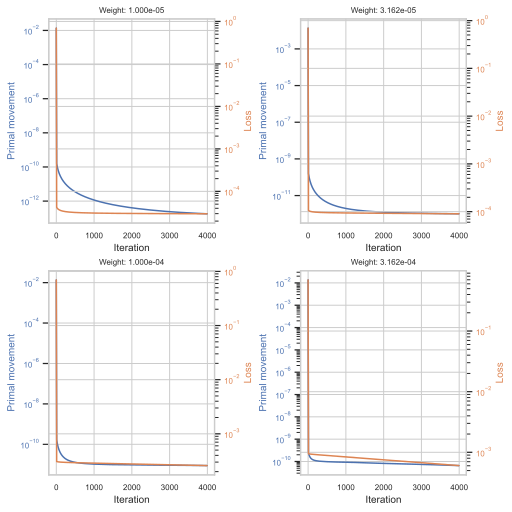

In [8]:
training = jtu.tree_map(lambda x: x[:200], lr_instance)
test = jtu.tree_map(lambda x: x[1500:], lr_instance)

fig, axes_ = plt.subplots(2, 2, figsize=(7, 7), layout="constrained")
axes = cast(list[Axes], axes_.flatten())
min_weight, max_weight = 1e-5, 1e-3
best_weight = 0
best_accuracy = 0
for i, ax in enumerate(axes):
    i_normalized = i / len(axes)
    weight = min_weight * (max_weight / min_weight) ** i_normalized
    accuracy, path, losses = weight_tune_test(
        weight, training, test, max_iter=4000
    )
    losses = losses + weight * jax.vmap(l1_regularizer)(path)
    visualize(path, losses, ax=ax)
    ax.set_title(f"Weight: {weight:.3e}")
    print(f"Weight: {weight:.7f}, Accuracy: {accuracy:.3f}")
    if accuracy > best_accuracy:
        best_weight = weight
        best_accuracy = accuracy

In [9]:
testset = jtu.tree_map(lambda x: x[1500:], lr_instance)


def find_best_weight(
    training: LinearRegression, max_iter: int = 5000
) -> tuple[float, float]:
    min_weight, max_weight = 1e-6, 100
    weights = jnp.exp(
        jnp.linspace(jnp.log(min_weight), jnp.log(max_weight), 100)
    )
    best_accuracy: float = 0
    best_weight: float = 0
    for weight in tqdm.tqdm(weights):
        accuracy = nfold_weight_tune_test(5, weight, training, max_iter)
        if accuracy > best_accuracy:
            best_weight = weight
            best_accuracy = accuracy
    return best_weight, best_accuracy

In [10]:
for training_size in [1500, 700, 200]:
    training = jtu.tree_map(lambda x: x[:training_size], lr_instance)
    best_weight, best_accuracy = find_best_weight(
        training, max_iter=200
    )
    test_error = 1 - best_accuracy
    print(
        f"Training size: {training_size}, Best weight: {best_weight:.7f}, Best test error: {test_error:.3f}"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

Training size: 1500, Best weight: 0.3125716, Best test error: 0.113


  0%|          | 0/100 [00:00<?, ?it/s]

Training size: 700, Best weight: 0.7924829, Best test error: 0.206


  0%|          | 0/100 [00:00<?, ?it/s]

Training size: 200, Best weight: 0.0231013, Best test error: 0.365


From this result, we do not see a monotone trend of the best weight with respect to the size of the training set(!). This is a bit surprising. (I re-tested this with different learning rates, but the general trend is confusing, and no clear-cut conclusion can be made.) The best error test rate naturally goes down when the training set size increases, because the model is more able to generalize and less likely to overfit when the training set is increased.


## Sub-gradient and Proximal Gradient Method

We have already implemented the sub-gradient and proximal gradient method above. Since $w^{r+1}=w^r-\tilde\nabla f(w^r)$, we compute the path of $w^r$ and plot the norm of its change, i.e. $\|w^{r+1}-w^r\|_2^2=\|\tilde\nabla f(w^r)\|_2^2$. See the right y axis for the required value.


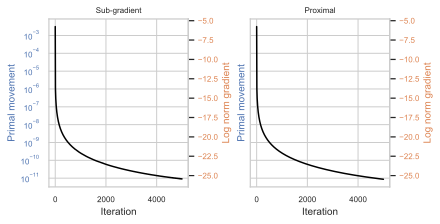

In [11]:
weight = 1e-4

trainset = jtu.tree_map(lambda x: x[:1500], lr_instance)
testset = jtu.tree_map(lambda x: x[1500:], lr_instance)

fig, axes = plt.subplots(
    1, 2, figsize=(6, 3), layout="constrained", sharey=True
)
axes = cast(list[Axes], list(axes.flatten()))


class TestSetup(NamedTuple):
    step: StepFunction
    name: str


test_setups = [
    TestSetup(
        step=partial(
            subgradient_step,
            regularizer=l1_regularizer,
            weight=weight,
            stepsize=1e-3,
        ),
        name="Sub-gradient",
    ),
    TestSetup(
        partial(
            proximal_gradient_step,
            regularizer=l1_regularizer,
            weight=weight,
            prox=l1_prox,
            stepsize=1e-3,
        ),
        name="Proximal",
    ),
]
for setup, ax in zip(test_setups, axes):
    path, losses = descent(
        jnp.zeros(trainset.X.shape[1]),
        trainset,
        setup.step,
        max_iter=5000,
    )
    visualize(path, losses, ax=ax, show_loss=False, stride=1)
    ax.set_title(setup.name)

We can see that both methods perform similarly.


## Stochastic Methods


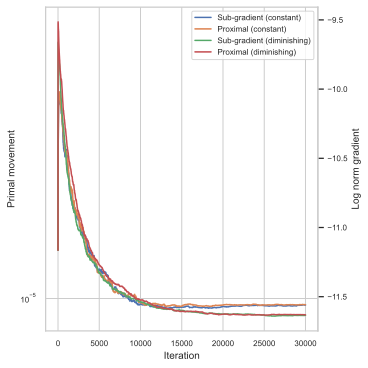

In [14]:
step_size_const = 1e-6


def step_size_diminishing(t: Integer[Scalar, ""]) -> Float[Scalar, ""]:
    return 1e-5 / jnp.sqrt(t)


@jax.jit
def true_loss(
    w: Float[Array, " d"], fun: TargetFn
) -> Float[Scalar, ""]:
    direc = -jax.grad(fun)(w)
    return jnp.linalg.norm(l1_prox(w + weight * direc, weight) - w) ** 2


test_setups = [
    TestSetup(
        step=partial(
            subgradient_step,
            regularizer=l1_regularizer,
            weight=weight,
            stepsize=step_size_const,
        ),
        name="Sub-gradient (constant)",
    ),
    TestSetup(
        partial(
            proximal_gradient_step,
            regularizer=l1_regularizer,
            weight=weight,
            prox=l1_prox,
            stepsize=step_size_const,
        ),
        name="Proximal (constant)",
    ),
    TestSetup(
        step=partial(
            subgradient_step,
            regularizer=l1_regularizer,
            weight=weight,
            stepsize=step_size_diminishing,
        ),
        name="Sub-gradient (diminishing)",
    ),
    TestSetup(
        partial(
            proximal_gradient_step,
            regularizer=l1_regularizer,
            weight=weight,
            prox=l1_prox,
            stepsize=step_size_diminishing,
        ),
        name="Proximal (diminishing)",
    ),
]

key0 = jr.key(20240318)
keys = jr.split(key0, len(test_setups))
fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
for setup, key in zip(test_setups, keys):
    path, losses = descent(
        jnp.zeros(trainset.X.shape[1]),
        trainset,
        setup.step,
        max_iter=30000,
        key0=key,
    )
    true_losses = jax.vmap(lambda w: true_loss(w, trainset))(path)
    ax.plot(true_losses, label=setup.name)

ax.set_yscale("log")
ax.set_xlabel("Iteration")
ax.set_ylabel("Primal movement")
second_y = ax.secondary_yaxis(
    "right",
    functions=(
        lambda x: np.log(np.abs(x) + 1e-18),
        lambda x: np.exp(np.minimum(x, 30)),
    ),
)
second_y.set_ylabel("Log norm gradient")
second_y.set_yscale("linear")
ax.legend()
plt.show()

We can see that after a sufficient number of iterations, the stochastic methods converge, and the algorithms with diminishing step size converge to a better solution. These methods has a much higher per-iteration performance than previous batched methods.
